<a href="https://colab.research.google.com/github/maksim267/RAG_attractions/blob/main/Copy_of_hf_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [ ]:
# !pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

In [ ]:
# !pip install --upgrade --force-reinstall numpy==2.1.0 pandas==2.2.2 packaging==24.2



In [ ]:
# pip install "langchain<0.1.0"

In [ ]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain_core.documents import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel
from sklearn.feature_extraction.text import TfidfVectorizer
#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

## Загрузка данных (4 балла)

In [ ]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

In [ ]:
data.head()

Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [ ]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [ ]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

In [ ]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [ ]:
corpus = [i for i in data.en_txt]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

words = vectorizer.get_feature_names_out()
mean_tfidf = np.mean(X.toarray(), axis=0)
sorted_indices = np.argsort(mean_tfidf)

print("Часто встречающиеся слова (низкий TF-IDF):")
for idx in sorted_indices[:10]:
  print(words[idx], mean_tfidf[idx])

print("\nРедкие и значимые слова (высокий TF-IDF):")
for idx in sorted_indices[-3:]:
  print(words[idx], mean_tfidf[idx])

In [ ]:
sentens_with_rar_word=[]
strange_words=['royalty','blender','bottroonirchich','method']
for sen in corpus:
  for word in strange_words:
    if word in sen:
      sentens_with_rar_word.append(sen)


In [ ]:
sentens_with_rar_word

In [ ]:
ind_bad_samples=data.loc[data.en_txt.isin(sentens_with_rar_word)].index

In [ ]:
data=data.drop(ind_bad_samples,axis=0)

In [ ]:
corpus = [i for i in data.Name]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

words = vectorizer.get_feature_names_out()
mean_tfidf = np.mean(X.toarray(), axis=0)
sorted_indices = np.argsort(mean_tfidf)

print("Часто встречающиеся слова (низкий TF-IDF):")
for idx in sorted_indices[:10]:
  print(words[idx], mean_tfidf[idx])

print("\nРедкие и значимые слова (высокий TF-IDF):")
for idx in sorted_indices[-10:]:
  print(words[idx], mean_tfidf[idx])

In [ ]:
data=data.loc[~data.description.isna()]

In [ ]:
# short_data = data.groupby("Name").apply(lambda x: x ==max([len(i) for i in x.en_txt])).reset_index()
idx = data.groupby("Name")["description"].apply(lambda x: x.str.len().idxmax())

short_data = data.loc[idx].reset_index(drop=True)

In [ ]:
short_data

In [ ]:
short_data['text']=short_data['Name']+', который описывают как '+short_data['description']+' расположенным в '+short_data['City']+' который выглядит как'+ short_data['en_txt']

In [ ]:
short_data.loc[short_data.text=='Дом Е.Д. Скрябиной расположенным в Екатеринбург который описывают: there is a man standing outside of a building with a tree in front of it']

In [ ]:
max([len(i) for i in short_data.text])

In [ ]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(
        page_content=doc["text"],
        metadata={"image": doc["image"],
                  'WikiData':doc['WikiData'],
                  'Lon&Lat':str(doc['Lon'])+' '+str(doc['Lat'])
                  }
    ) for _, doc in tqdm(short_data.iterrows())
]

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [ ]:
# pip install -U langchain

In [ ]:
# embedding_model = HuggingFaceEmbeddings(
#     model_name=EMBEDDING_MODEL_NAME,
#     multi_process=True,
#     model_kwargs={"device": "cuda"},
#     encode_kwargs={"normalize_embeddings": True},  # `True` для косинусного сходства
# )

# KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
#     docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
# )

In [ ]:
# !pip install chromadb

In [23]:
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from ragatouille import RAGPretrainedModel

query='достопримечательность в Екатеринбурге'
# 1. Эмбеддинги
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vecstore = Chroma.from_documents(RAW_KNOWLEDGE_BASE, embeddings)

# 3. Получаем кандидатов
retriever = vecstore.as_retriever(search_kwargs={"k": 10})
candidates = retriever.get_relevant_documents(query)

# 4. Ранжируем через RAGatouille
rag = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
# texts = list(set([doc.page_content for doc in candidates]))
rag.index([doc.page_content for doc in candidates], index_name="my_index")
reranked = rag.search(query, k=5)

# 5. Передаём топ‑5 чанков в LLM
for rank, res in enumerate(reranked, 1):
    print(f"{rank}. {res['content']} (score={res['score']:.4f})")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

artifact.metadata: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 16:32:35] #> Creating directory .ragatouille/colbert/indexes/my_index 


[Nov 16, 16:32:37] [0] 		 #> Encoding 10 passages..


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


[Nov 16, 16:32:38] [0] 		 avg_doclen_est = 114.5 	 len(local_sample) = 10
[Nov 16, 16:32:38] [0] 		 Creating 512 partitions.
[Nov 16, 16:32:38] [0] 		 *Estimated* 1,145 embeddings.
[Nov 16, 16:32:38] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/my_index/plan.json ..
used 5 iterations (0.2712s) to cluster 1088 items into 512 clusters
[Nov 16, 16:32:38] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


W1116 16:32:38.926000 2791 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1116 16:32:38.926000 2791 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[Nov 16, 16:35:42] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


W1116 16:35:42.497000 2791 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1116 16:35:42.497000 2791 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[0.024, 0.021, 0.019, 0.024, 0.024, 0.021, 0.023, 0.025, 0.016, 0.02, 0.026, 0.025, 0.026, 0.022, 0.02, 0.021, 0.022, 0.025, 0.022, 0.027, 0.021, 0.023, 0.025, 0.023, 0.022, 0.024, 0.028, 0.023, 0.021, 0.024, 0.025, 0.023, 0.024, 0.019, 0.02, 0.029, 0.023, 0.021, 0.025, 0.02, 0.019, 0.018, 0.023, 0.024, 0.016, 0.022, 0.022, 0.021, 0.023, 0.022, 0.025, 0.024, 0.017, 0.024, 0.027, 0.022, 0.025, 0.03, 0.024, 0.025, 0.018, 0.022, 0.021, 0.027, 0.024, 0.02, 0.023, 0.019, 0.019, 0.021, 0.021, 0.021, 0.024, 0.022, 0.017, 0.025, 0.023, 0.022, 0.021, 0.02, 0.029, 0.017, 0.023, 0.024, 0.021, 0.022, 0.023, 0.023, 0.024, 0.025, 0.025, 0.026, 0.024, 0.027, 0.028, 0.022, 0.025, 0.023, 0.018, 0.031, 0.023, 0.025, 0.021, 0.017, 0.023, 0.023, 0.021, 0.021, 0.026, 0.023, 0.025, 0.02, 0.026, 0.026, 0.027, 0.02, 0.025, 0.02, 0.026, 0.023, 0.019, 0.023, 0.024, 0.022, 0.027, 0.027, 0.024, 0.024]


0it [00:00, ?it/s]

[Nov 16, 16:37:00] [0] 		 #> Encoding 10 passages..


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
1it [00:00,  7.52it/s]
100%|██████████| 1/1 [00:00<00:00, 1186.51it/s]

[Nov 16, 16:37:00] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 16:37:00] #> Building the emb2pid mapping..
[Nov 16, 16:37:00] len(emb2pid) = 1145



100%|██████████| 512/512 [00:00<00:00, 29866.40it/s]

[Nov 16, 16:37:00] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 16:37:02] #> Loading codec...
[Nov 16, 16:37:02] #> Loading IVF...
[Nov 16, 16:37:02] #> Loading doclens...


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
100%|██████████| 1/1 [00:00<00:00, 1709.17it/s]

[Nov 16, 16:37:02] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 340.09it/s]


Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: достопримечательность в Екатеринбурге, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  1184, 14150, 29747, 22919, 14150, 29746, 16856, 10325,
        29745, 15290, 29752, 10260, 22919, 15290, 29436, 23742, 18947, 14150,
        29747, 22919, 23742,  1182,  1185, 28598, 22919, 15290, 16856, 10325,
        18947,   102], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

1. Дом связи (Екатеринбург), который описывают как здание в Екатеринбурге расположенным в Екатеринбург который выглядит какarafed building with a blue sign on the front of it (score=27.0000)
2. Дом Промышленности, который описывают как здание в Екатеринбурге расположенным в Екатеринбург который выглядит какarafed building with a lot of windows and a lot of cars (score

In [24]:
READER_MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME,
    quantization_config=bnb_config,
    device_map="cuda"
)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    device="cuda:0",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)



config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

ValueError: The model has been loaded with `accelerate` and therefore cannot be moved to a specific device. Please discard the `device` argument when creating your pipeline object.

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap

emb_matrix = np.array([embeddings.embed_query(doc.page_content) for doc in RAW_KNOWLEDGE_BASE])

# ================
# 1. PCA (2 компоненты)
# ================
pca = PCA(n_components=2, random_state=42)
emb_pca = pca.fit_transform(emb_matrix)

# ================
# 2. UMAP (2 компоненты)
# ================
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
emb_umap = umap_model.fit_transform(emb_matrix)

plt.figure(figsize=(14,6))

# PCA Plot
plt.subplot(1, 2, 1)
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], s=15, alpha=0.7)
plt.title("PCA Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")

# UMAP Plot
plt.subplot(1, 2, 2)
plt.scatter(emb_umap[:, 0], emb_umap[:, 1], s=15, alpha=0.7, c='orange')
plt.title("UMAP Visualization")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

plt.show()


# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

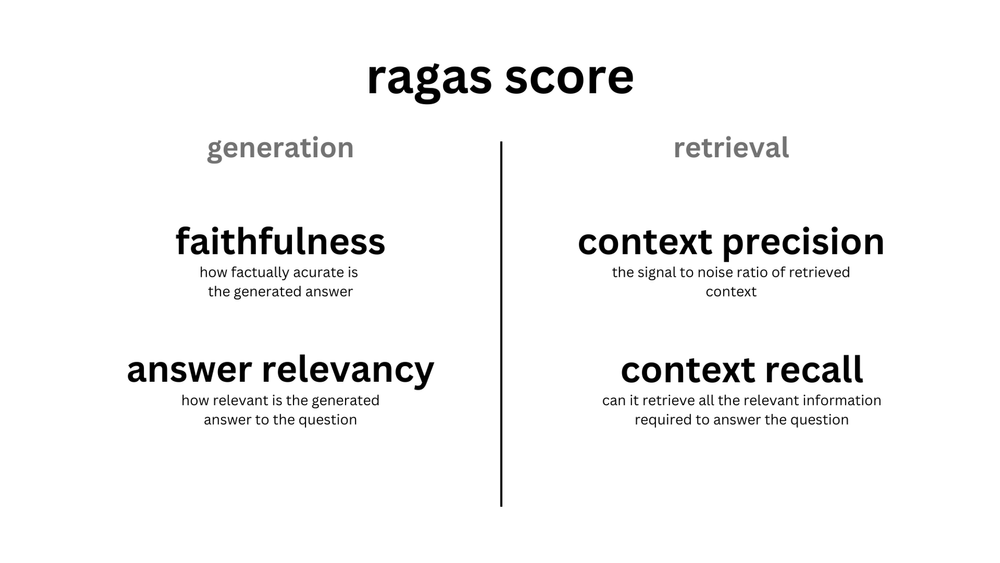

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [ ]:
def answer_relevancy(question,embeddings,answer,N=3):
  vec_question = embeddings.embed_documents(question)
  vec_ansver = embeddings.embed_documents(answer)
  cos_sim = np.sum(vec_question * vec_ansver, axis=1) / (
    np.linalg.norm(vec_question, axis=1) * np.linalg.norm(vec_ansver, axis=1)
)
  return cos_sim

In [ ]:
(data['Name']+', который описывают как '+data['description']+' расположенным в '+data['City']+' который выглядит как'+ data['en_txt']).to_csv('data_for_question_rag5.csv')
# для генерации вопросов и ответов я использовал deepseek

###Сгенерированные DeepSeek вопросы и ответы

In [ ]:
questions = [
    "What is Dinamo?",
    "Where is Dinamo?",
    "What is Dom Oborony?",
    "What is on Dom Oborony's roof?",
    "What is the 'Luch' Power Station?",
    "Where is the 'Luch' Power Station?",
    "What is the Skryabin House?",
    "Where is the Skryabin House?",
    "What is 'Literary Life of the Urals'?",
    "Where is 'Literary Life of the Urals'?",
    "What is the Bazhov House?",
    "Where is the Bazhov House?",
    "What is the Puppet Theater?",
    "Where is the Puppet Theater?",
    "What is Kharitonovsky Park?",
    "Where is Kharitonovsky Park?",
    "What is the Church of the Ascension?",
    "Where is the Church of the Ascension?",
    "What is the Suvorov School?",
    "Where is the Suvorov School?",
    "What is the Holy Trinity Cathedral?",
    "Where is the Holy Trinity Cathedral?",
    "What is the Mamin-Sibiryak House?",
    "Where is the Mamin-Sibiryak House?",
    "What is the Ernst Neizvestny Museum?",
    "Where is the Ernst Neizvestny Museum?",
    "What is the Ordzhonikidze Monument?",
    "Where is the Ordzhonikidze Monument?",
    "What is the Kuznetsov Monument?",
    "Where is the Kuznetsov Monument?",
    "What is the Uspensky Cathedral?",
    "Where is the Uspensky Cathedral?",
    "What is the Tsarsky Bridge?",
    "Where is the Tsarsky Bridge?",
    "What is Dom Pechati?",
    "Where is Dom Pechati?",
    "What is the Museum of Fine Arts?",
    "Where is the Museum of Fine Arts?",
    "What is the Alexander Nevsky Cathedral?",
    "Where is the Alexander Nevsky Cathedral?",
    "What is the Madrid Hotel?",
    "Where is the Madrid Hotel?",
    "What is the Yekaterinburg Museum of Fine Arts?",
    "Where is the Yekaterinburg Museum of Fine Arts?",
    "What is the Medical University?",
    "Where is the Medical University?",
    "What is the Central Stadium?",
    "Where is the Central Stadium?",
    "What is the Conservatory?",
    "Where is the Conservatory?",
    "What is the Metenkov Photo Museum?",
    "Where is the Metenkov Photo Museum?",
    "What is the Preobrazhenskaya Church?",
    "Where is the Preobrazhenskaya Church?",
    "What is the Geological Museum?",
    "Where is the Geological Museum?",
    "What is Dom Metenkova?",
    "Where is Dom Metenkova?",
    "What is Gymnasium No. 9?",
    "Where is Gymnasium No. 9?",
    "What is the Second House of Soviets?",
    "Where is the Second House of Soviets?",
    "What is the Water Tower?",
    "Where is the Water Tower?",
    "What type of place is Dinamo?",
    "What city is Dinamo in?",
    "What color is Dinamo?",
    "What is on Dom Oborony?",
    "What type of building is Dom Oborony?",
    "What city is Dom Oborony in?",
    "What type of place is 'Luch'?",
    "What material is 'Luch' made of?",
    "What feature does Skryabin House have?",
    "What material is Skryabin House?",
    "What type of place is 'Literary Life of the Urals'?",
    "What type of building houses it?",
    "What type of house is Bazhov House?",
    "What color is its roof?",
    "What feature does Puppet Theater have?",
    "What type of place is Puppet Theater?",
    "What is in Kharitonovsky Park?",
    "What city is the park in?",
    "What color is Church of the Ascension?",
    "What feature does it have?",
    "What type of school is Suvorov?",
    "What is in front of it?",
    "What color is Holy Trinity Cathedral?",
    "What color are its domes?",
    "What color is Mamin-Sibiryak House?",
    "What color is its roof?",
    "What does Neizvestny Museum display?",
    "What type of museum is it?",
    "Where is Ordzhonikidze Monument located?",
    "What type of monument is it?",
    "Where is Kuznetsov Monument located?",
    "What is he holding?",
    "What color are Uspensky Cathedral's domes?",
    "Where is it located?",
    "What river does Tsarsky Bridge cross?",
    "What is on the bridge?",
    "What size is Dom Pechati?",
    "What feature does it have?",
    "What color is Fine Arts Museum's roof?",
    "Where is it located?",
    "What color is Alexander Nevsky Cathedral?",
    "What color are its domes?",
    "What feature does Madrid Hotel have?",
    "What type of place is it?",
    "What does Yekaterinburg Fine Arts Museum display?",
    "What type of place is it?",
    "What feature does Medical University have?",
    "What feature is on the building?",
    "What sport is Central Stadium for?",
    "What color is its roof?",
    "What type of school is Conservatory?",
    "What type of hall does it have?",
    "What color is Metenkov Museum?",
    "What type of museum is it?",
    "What color is Preobrazhenskaya Church?",
    "What color is its roof?",
    "What does Geological Museum display?",
    "What size are the rocks?",
    "What type of place is Dom Metenkova?",
    "What color is the building?",
    "What type of place is Gymnasium No. 9?",
    "What feature does it have?",
    "What size is Second House of Soviets?",
    "What feature does it have?",
    "How tall is Water Tower?",
    "What feature does it have?"
]

answers = [
    "A sports complex",
    "In Yekaterinburg",
    "A building",
    "A plane",
    "A power station",
    "In Yekaterinburg",
    "A house",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A house-museum",
    "In Yekaterinburg",
    "A theater",
    "In Yekaterinburg",
    "A park",
    "In Yekaterinburg",
    "A church",
    "In Yekaterinburg",
    "A military school",
    "In Yekaterinburg",
    "A cathedral",
    "In Yekaterinburg",
    "A house-museum",
    "In Yekaterinburg",
    "An art museum",
    "In Yekaterinburg",
    "A monument",
    "In Yekaterinburg",
    "A monument",
    "In Yekaterinburg",
    "A cathedral",
    "On VIZ, Yekaterinburg",
    "A bridge",
    "Over the Iset River, Yekaterinburg",
    "A building",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A cathedral",
    "In Yekaterinburg",
    "A hotel",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A university",
    "In Yekaterinburg",
    "A stadium",
    "In Yekaterinburg",
    "A music school",
    "In Yekaterinburg",
    "A photo museum",
    "In Yekaterinburg",
    "A church",
    "On Uktus, Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A school",
    "In Yekaterinburg",
    "A building",
    "In Yekaterinburg",
    "A tower",
    "In Yekaterinburg",
    "Sports complex",
    "Yekaterinburg",
    "Blue and white",
    "A plane",
    "A building",
    "Yekaterinburg",
    "Power station",
    "Red brick",
    "A clock",
    "Red brick",
    "Museum",
    "Wooden house",
    "Log cabin",
    "Green",
    "Clock tower",
    "Theater",
    "A pond",
    "Yekaterinburg",
    "Blue and white",
    "Clock tower",
    "Military",
    "Statues",
    "Yellow",
    "Golden",
    "Red",
    "Green",
    "Sculptures",
    "Art museum",
    "In a park",
    "A statue",
    "In a park",
    "A flag",
    "Blue",
    "On VIZ",
    "Iset River",
    "Graffiti",
    "Large",
    "A clock",
    "Green",
    "Near a river",
    "White",
    "Gold",
    "Clock tower",
    "Hotel",
    "Paintings",
    "Museum",
    "Columns",
    "A clock",
    "Soccer",
    "Colored",
    "Music",
    "Concert hall",
    "Yellow",
    "Photo museum",
    "White",
    "Green",
    "Rocks",
    "Large",
    "Museum",
    "Yellow",
    "School",
    "A clock",
    "Large",
    "Clock tower",
    "Tall",
    "A clock"
]

In [ ]:
row_numbers_used = [
    "0-40", "0-40", "41-96", "41,43,47,50-53,65,66,68,69,80,93", "97-123", "97-123",
    "123-150", "123-150", "151-177", "151-177", "178-207", "178-207", "207-246", "207-246",
    "247-277", "247-277", "278-334", "278-334", "335-367", "335-367", "368-397", "368-397",
    "398-426", "398-426", "427-453", "427-453", "454-510", "454-510", "511-540", "511-540",
    "541-568", "541-568", "569-608", "569-608", "609-638", "609-638", "639-666", "639-666",
    "667-693", "667-693", "694-722", "694-722", "723-750", "723-750", "751-779", "751-779",
    "779-818", "779-818", "819-849", "819-849", "850-908", "850-908", "909-964", "909-964",
    "965-1020", "965-1020", "1021-1050", "1021-1050", "1051-1078", "1051-1078", "1079-1108",
    "1079-1108", "1109-1135", "1109-1135", "0-40", "0-40", "1,2,3,8,9,10,15,22,28,30",
    "41,43,47,50-53,65,66,68,69,80,93", "41-96", "41-96", "97-123", "97-123", "123-150",
    "123-150", "151-177", "151-177", "178-207", "178-207", "207-246", "207-246", "247-277",
    "247-277", "278-334", "278-334", "335-367", "335-367", "368-397", "368-397", "398-426",
    "398-426", "427-453", "427-453", "454-510", "454-510", "511-540", "511-540", "541-568",
    "541-568", "569-608", "569-608", "609-638", "609-638", "639-666", "639-666", "667-693",
    "667-693", "694-722", "694-722", "723-750", "723-750", "751-779", "751-779", "779-818",
    "779-818", "819-849", "819-849", "850-908", "850-908", "909-964", "909-964", "965-1020",
    "965-1020", "1021-1050", "1021-1050", "1051-1078", "1051-1078", "1079-1108", "1079-1108",
    "1109-1135", "1109-1135"
]

###Продолжение

In [ ]:
def gen_LLM_answers(questions_list:list,LLm,retriever,rag):
  answers=[]
  for question in tqdm(questions_list):
    candidates = retriever.get_relevant_documents(question)
    rag.index([doc.page_content for doc in candidates], index_name="my_index")
    rest = rag.search(question, k=5)
    prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
    give a comprehensive answer to the question.
    Respond only to the question asked, response should be concise and relevant to the question.
    Provide the number of the source document when relevant.
    If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
    {context}
    ---
    Now here is the question you need to answer.

    Question: {question}""",
    },
    ]
    RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
      prompt_in_chat_format, tokenize=False, add_generation_prompt=True
    )
    context = "\nExtracted documents:\n"
    context += "".join([
    f"Document {i}:::\n{res['content']}\n"
    for i, res in enumerate(rest)
    ])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = READER_LLM(final_prompt)[0]["generated_text"]
    answers.append(answer)

  return answers

# Протестируйте ваш RAG (3 балла)

In [ ]:
answers_LLM=gen_LLM_answers(questions,READER_LLM,retriever,rag)

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here